# Clasificación de Sargazo

Notebook inicial para clasificar el nivel de sargazon en imágenes de la playa. Tu puedes dividir el conjunto de datos entre entrenamiento y validación.

In [ ]:
import numpy as np
import pandas as pd #Dataframes
import matplotlib.pyplot as plt
from skimage import io, transform #procesamiento de imagenes y transformaciones de imagenes
from PIL import Image  #procesamiento de imagenes, manipulación de imagenes
import os #permite manipular rutas de archivos y directorios
import time #medir tiempo de ejecuciones
import copy

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn #redes neuronales
import torchvision #harramientas y conjuntos de datos para visión por computadora
from torch.autograd import Variable #rastrear operaciones y calcular automaticamente los gradientes durante la retropropagación
from torchvision import datasets, models, transforms, utils
import torch.optim as optim #algoritmos de optimizacion para actualizar pesos
import sklearn
import sklearn.model_selection as skl
import seaborn as sn #permite visualización de datos mediante la creacion de graficos
%matplotlib inline
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
!python --version

cuda:0
Torch version:  2.1.0+cu121
Torchvision version:  0.16.0+cu121
Python 3.10.12


In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Directorio de la carpeta "sargazo" donde está el dataset en Google Drive
sargazo_folder = '/content/drive/My Drive/redes_sargazo'
img_folder = f'{sargazo_folder}/images'
csv_file = f'{sargazo_folder}/train.csv'

# Hyper parameters
epochs = 25
current_epoch = 0
batch_size = 32
learning_rate = 0.001
run_training = True #Si deseamos que el notebook ejecute el entrenamiento
model_name = 'vgg' # Red a cargar
pretrained = True # True indica que la red se va a inicializar con los parámetros entrenados
feature_extract = False #True indica que no se actualizan los parámetros
save_weights = True

wts_str = 'w_' + model_name + '_pret_' + str(pretrained) + '_feat_' + str(feature_extract) + '_lr_'+ str(learning_rate)
print(wts_str)

Mounted at /content/drive
w_vgg_pret_True_feat_False_lr_0.001


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Objeto Dataset

In [ ]:
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        """
        Args:
            txt_frame_file (string): Path to the txt files with labels.
            images_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sargazo_frame = dataframe
        self.root_dir = images_path
        self.transform = transform
        self.class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}

    def pil_loader(self, path): #cargamos una imagen dada su ruta
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __len__(self): #longitud total de conjunto de datos
        return len(self.sargazo_frame)

    def __getitem__(self, idx): # obtiene un elemento del conjunto de datos
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # cuidado si cambia la tabla se debe de cambiar esto
        image_path = os.path.join(self.root_dir, self.sargazo_frame.iloc[idx, 1])

        image = self.pil_loader(image_path) #carga la imagen

        try:
            label = self.sargazo_frame.iloc[idx, 4]
        except:
            label = 'unknown'

        if self.transform is not None:
            image = self.transform(image) #preprocesamiento de imagenes

        sample = (image, self.class2id[label]) #imagen, etiqueta con su correspondiente identificador

        return sample

## Dividir conjunto de datos

In [ ]:
class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {0: 'nada', 1: 'bajo', 2: 'moderado', 3: 'abundante', 4: 'excesivo'}
num_classes = len(id2class)

full_dataset = pd.read_csv(csv_file) #utilizando pandas se lee el archivo
full_dataset.sample(5)

print(full_dataset.iloc[0, 1]) #imprime una muestra aleatoria de 2 filas

excesivo


In [ ]:
col_labels = 'Category'
random = 46 # for reproducible experiments
train_df, valid_df = skl.train_test_split(full_dataset, test_size = 0.2, stratify = full_dataset[col_labels], random_state = random)
#division de datos en conjuntos de entrenamiento y validacion

#creación de instancias
training_dataset = SargazoDataset(train_df, img_folder)
test_dataset = SargazoDataset(valid_df, img_folder)
print("Número de ejemplos:", len(training_dataset)) #imprime la cantidad de datos

def show_image(image, label):
    plt.imshow(image, cmap = 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

Número de ejemplos: 1196


## Mostrar unos ejemplos

In [ ]:
fig = plt.figure()

for i in range(len(full_dataset)):
    sample = training_dataset[i]
    image, label = sample

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} Class {}'.format(i, id2class[label]))
    ax.axis('off')
    show_image(image, label)

    if i == 3:
        plt.show()
        break

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/redes_sargazo/images/nada'

<Figure size 640x480 with 0 Axes>

## Descenso por gradiente

Implementación del descenso por gradiente.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 25, is_inception= False, save_after = 100):
    since = time.time() #tiempo del entrenamiento

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 #mejor precision

    #print(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))

        #Each epoch as a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data iteracion sobre lotes de datos
            for inputs, labels in iter(dataloaders[phase]):
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                #zero the parameter gradients
                optimizer.zero_grad()

                #forward
                # track history
                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss /len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), wts_str + '_best.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

            if phase == 'train' and epoch % save_after == 0 :
                torch.save(model.state_dict(), wts_str + '_epoch' + str(epoch) + '.pt')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    #load the best model
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

In [ ]:
# set model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # Freeze parameters
            param.requires_grad = False

## Crear modelo de red neuronal

In [ ]:
# Initialize and reshape the networks
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        #model_ft = models.vgg16(weights='IMAGENET1K_V1')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrained)

# Print the model we just instantiated
print(model_ft)

model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Entrenamiento

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# configure paths to the description txt file and the images folder
#images_path = '../input/sargazo-dataset/sargazo_dataset/images'

# Create training and validation datasets
image_datasets = {'train': SargazoDataset(train_df, img_folder, data_transforms['train']), 'val': SargazoDataset(valid_df, img_folder, data_transforms['val'])}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# create the optimizer
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

optimizer_ft = optim.SGD(params_to_update, lr=learning_rate,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Params to learn
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
#model_ft.load_state_dict(torch.load('w_vgg_pret_True_feat_False_lr_0.001_best.pt'))

In [ ]:
# Execute full training
if run_training:
    model_ft, hist, hist_t,loss_hist,loss_hist_t = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs = epochs, is_inception=(model_name=="inception"))

Epoch 0/24
train Loss: 1.1442 Acc: 0.5460
val Loss: 1.0012 Acc: 0.5967

Epoch 1/24
train Loss: 1.0134 Acc: 0.5962
val Loss: 0.8594 Acc: 0.6367

Epoch 2/24
train Loss: 0.9234 Acc: 0.6321
val Loss: 0.8949 Acc: 0.6000

Epoch 3/24
train Loss: 0.8817 Acc: 0.6572
val Loss: 0.7452 Acc: 0.7100

Epoch 4/24
train Loss: 0.8420 Acc: 0.6538
val Loss: 0.7438 Acc: 0.7233

Epoch 5/24
train Loss: 0.7833 Acc: 0.6923
val Loss: 0.7587 Acc: 0.7067

Epoch 6/24
train Loss: 0.7499 Acc: 0.7140
val Loss: 0.7247 Acc: 0.7000

Epoch 7/24
train Loss: 0.7413 Acc: 0.7149
val Loss: 0.7451 Acc: 0.7433

Epoch 8/24
train Loss: 0.7249 Acc: 0.7283
val Loss: 0.7225 Acc: 0.7400

Epoch 9/24
train Loss: 0.6701 Acc: 0.7458
val Loss: 0.7555 Acc: 0.7267

Epoch 10/24
train Loss: 0.7055 Acc: 0.7224
val Loss: 0.7507 Acc: 0.7400

Epoch 11/24
train Loss: 0.6129 Acc: 0.7659
val Loss: 0.7717 Acc: 0.7033

Epoch 12/24
train Loss: 0.6309 Acc: 0.7584
val Loss: 0.7792 Acc: 0.7233

Epoch 13/24
train Loss: 0.5784 Acc: 0.7734
val Loss: 0.7724 A

In [ ]:
if save_weights:
    torch.save(model_ft.state_dict(), wts_str)

## Graficar resultados

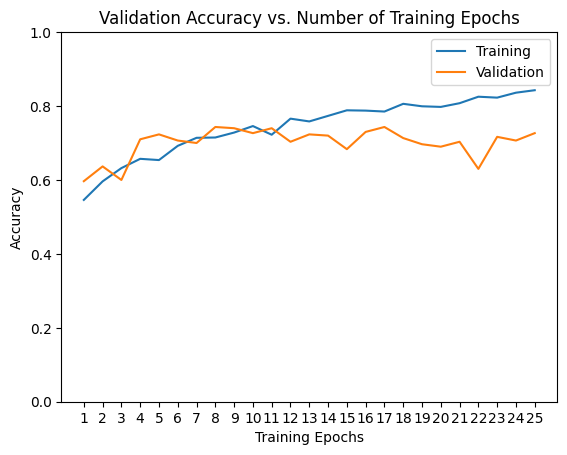

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
thist = []

vhist = [h.cpu().numpy() for h in hist]
thist = [h.cpu().numpy() for h in hist_t]
#shist = [h.cpu().numpy() for h in scratch_hist]

np.save('val_history', vhist)
np.save('train_history', vhist)

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,epochs+1),thist,label="Training")
plt.plot(range(1,epochs+1),vhist,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_acc.png'
plt.savefig(file_name)
plt.show()


#Si la curva de validación comienza a aplanarse mientras la de entrenamiento
# sigue aumentando, podría haber signos de sobreajuste
# Si hay oscilaciones significativas, el modelo podría beneficiarse
# de técnicas como la regularización.


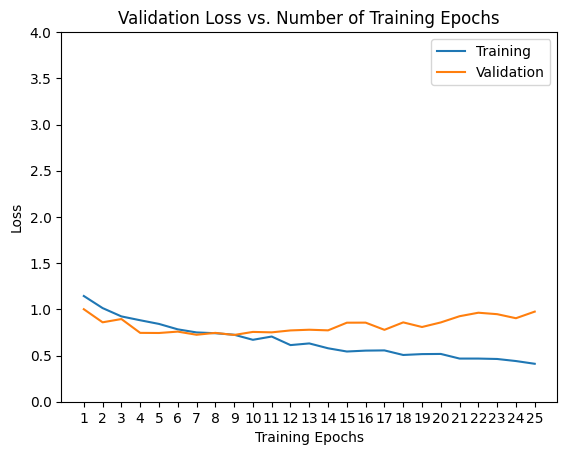

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist_loss = np.array(loss_hist)
thist_loss = np.array(loss_hist_t)

np.save('val_history', vhist_loss)
np.save('train_history', thist_loss)

plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1),thist_loss,label="Training")
plt.plot(range(1,epochs+1),vhist_loss,label="Validation")
plt.ylim((0,4.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_loss.png'
plt.savefig(file_name)
plt.show()

In [ ]:
def test_model(model, dataloaders):
    print("Evaluating model")
    print(time.time())

    # Iterate over data
    it = 0
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        model.train(False)
        model.eval()

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        np_pred_labels = preds.cpu().numpy()
        np_real_labels = labels.cpu().numpy()
        if it == 0:
            pred_labels = np_pred_labels
            real_labels = np_real_labels
        else:
            pred_labels = np.concatenate((pred_labels,np_pred_labels))
            real_labels = np.concatenate((real_labels,np_real_labels))
        it= it+1

        del inputs
        del labels
        torch.cuda.empty_cache()

    print(time.time())
    return pred_labels,real_labels

In [ ]:
predict_labels,actual_labels = test_model(model_ft, dataloaders_dict)

Evaluating model
1704767536.908709
1704767544.8377957


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual_labels,predict_labels))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87       174
           1       0.65      0.51      0.57        69
           2       0.42      0.32      0.36        31
           3       0.71      0.36      0.48        14
           4       0.82      0.75      0.78        12

    accuracy                           0.74       300
   macro avg       0.68      0.58      0.61       300
weighted avg       0.72      0.74      0.73       300



In [ ]:
df_confusion = pd.crosstab(actual_labels, predict_labels,rownames=["True label"],colnames=["Predicted label"])
print(df_confusion)
df_confusion.rename(columns=id2class,index=id2class,inplace=True)
print(df_confusion)
df_confusion.to_csv('cm_exp5.csv')

Predicted label    0   1   2  3  4
True label                        
0                164   9   1  0  0
1                 27  35   6  0  1
2                 13   7  10  1  0
3                  0   3   5  5  1
4                  0   0   2  1  9
Predicted label  nada  bajo  moderado  abundante  excesivo
True label                                                
nada              164     9         1          0         0
bajo               27    35         6          0         1
moderado           13     7        10          1         0
abundante           0     3         5          5         1
excesivo            0     0         2          1         9


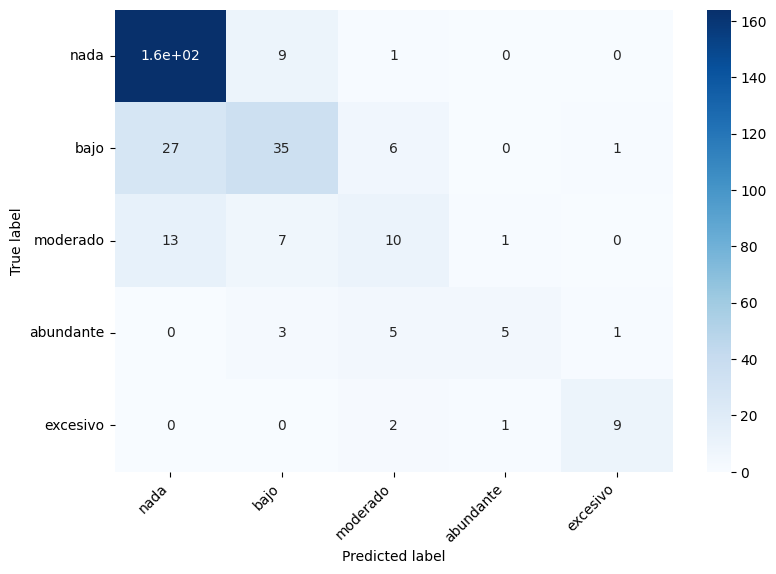

In [ ]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_confusion, annot = True, cmap = 'Blues',ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5.eps",format = "eps",bbox_inches='tight')
plt.show()

In [ ]:
df_norm_col= round(df_confusion.div(df_confusion.sum(axis=1),axis=0),2)
print(df_norm_col)

Predicted label  nada  bajo  moderado  abundante  excesivo
True label                                                
nada             0.94  0.05      0.01       0.00      0.00
bajo             0.39  0.51      0.09       0.00      0.01
moderado         0.42  0.23      0.32       0.03      0.00
abundante        0.00  0.21      0.36       0.36      0.07
excesivo         0.00  0.00      0.17       0.08      0.75


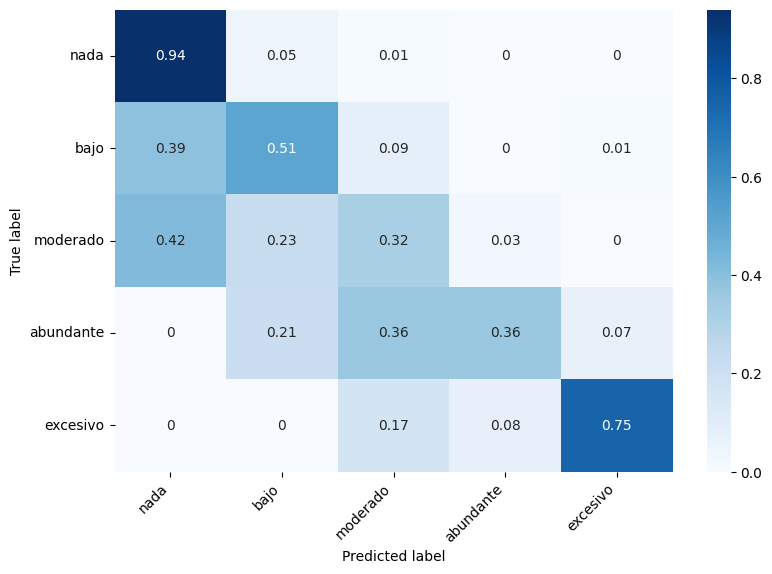

In [ ]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_norm_col, annot = True, cmap = 'Blues')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5_norm.eps",format = "eps",bbox_inches='tight')
plt.show()

## Inferencia para el challenge

In [ ]:
test_file = '/content/drive/My Drive/sargazo_dataset/sargazo_dataset/labels/test.csv'

In [ ]:
test_df = pd.read_csv(test_file)
test_df.sample(5)


,Unnamed: 0,image_name,place,date
26,1170,s0447.jpg,Playa del Carmen,14/08/2019
33,183,k0228.jpg,desconocido,desconocido
159,1307,s0604.jpg,Tulum,31/08/2019
4,387,k0461.jpg,desconocido,desconocido
96,121,k0153.jpg,desconocido,desconocido


In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


model_ft.eval()
test_predictions = []
for file in test_df['image_name']:

    # cuidado si cambia la tabla se debe de cambiar esto
    image_path = os.path.join(img_folder, file)
    #print(image_path)

    image = pil_loader(image_path)
    img_transf = data_transforms['val'](image)
    img_transf = img_transf.unsqueeze(0)
    #print(img_transf.shape)

    #print(labels)
    img_transf = img_transf.to(device)

    outputs = model_ft(img_transf)
    #print(outputs)
    _, preds = torch.max(outputs, 1)
    test_predictions.append(id2class[preds.cpu().numpy()[0]])

#print(test_predictions)
temp = {'Id': test_df['image_name'], 'Category': test_predictions}
output_df = pd.DataFrame(data=temp)
output_df.sample(10)

output_df.to_csv('outputs.csv', index=False)